In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import wordcloud,STOPWORDS
from PIL import Image
import distance
from fuzzywuzzy import fuzz
from nltk.stem import PorterStemmer
from wordcloud import WordCloud , STOPWORDS


#df = pd.read_csv("df_fe_without_preprocessing",encoding='latin-1')
#df = df.fillna('')
#df.head()


## Preprocessing text

In [22]:
# to get the resut in 4 decimal places
safe_div = 0.0001 
STOP_WORDS = stopwords.words('English')

def preprocess(x):
    
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(""):
        x = re.sub(pattern , " " , x)
        
    if type(x) == type(""):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    return x
    
    
    
    
    

## Features

Definition:

Token: You get a token by splitting sentence a space
Stop_Word : stop words as per NLTK.
Word : A token that is not a stop_word
Features:

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))



cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))



csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))



csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))



ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))



ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))



last_word_eq : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])



first_word_eq : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])



abs_len_diff : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))



mean_len : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2



fuzz_ratio 

fuzz_partial_ratio

token_sort_ratio

token_set_ratio 

longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [34]:
def get_token_features(q1,q2):
    token_features = [0.0]*10
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    #getting the non stop words in the tokens
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #getting the stopwords
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #getting the common non stop words from the question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    #getting the common stop words from the question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    #getting the common tokens altogether
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words),len(q2_words)) + safe_div)
    token_features[1] = common_word_count / (max(len(q1_words),len(q2_words)) + safe_div)
    token_features[2] = common_stop_count / (min(len(q1_stops),len(q2_stops)) + safe_div)
    token_features[3] = common_stop_count / (max(len(q1_stops),len(q2_stops)) + safe_div)
    token_features[4] = common_token_count / (min(len(q1_tokens),len(q2_tokens)) + safe_div)
    token_features[5] = common_token_count / (max(len(q1_tokens),len(q2_tokens)) + safe_div)
    #checking for last word
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1] )
    #checking for first word
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    #average token length of both q1 and q2
    token_features[8] = (len(q1_tokens)+len(q2_tokens)) / 2
    
    return token_features

def get_longest_substr_ratio(q1,q2):
    
    strs = list(distance.lcsubstrings(q1,q2))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(q1),len(q2))+1)

def extract_features(df):
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    print("token features...")
    
    #merging token with dataset
    
    token_features = df.apply(lambda sentence : get_token_features(sentence["question1"],sentence["question2"]),axis = 1)

    df["cwc_min"] = list(map(lambda x : x[0] , token_features))
    df["cwc_max"] = list(map(lambda x : x[1], token_features))
    df["csc_min"] = list(map(lambda x : x[2] , token_features))
    df["csc_max"] = list(map(lambda x : x[3] , token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))
    
    print("fuzzy features...")
    
    df["token_set_ratio"] = df.apply(lambda x : fuzz.token_set_ratio(x["question1"],x["question2"]),axis=1)
    df["token_sort_ration"] = df.apply(lambda x : fuzz.token_sort_ratio(x["question1"],x["question2"]),axis = 1)
    df["fuzz_ratio"]  = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"] = df.apply(lambda x : fuzz.partial_ratio(x["question1"],x["question2"]),axis = 1)
    df["longest_substr_ratio"] = df.apply(lambda x : get_longest_substr_ratio(x["question1"],x["question2"]),axis =1)
    
    return df

    
    
    
    
    

    
    
    
    
    
    
    

In [35]:
if os.path.isfile("nlp_features_train.csv"):
    df = pd.read_csv("nlp_features_train.csv")
else:
    print("extracting features from train : ")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
    df.head(2)

extracting features from train : 
token features...
fuzzy features...


In [45]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ration,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,13.0,0.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,12.5,0.0,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,12.0,0.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,12.0,0.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,10.0,0.0,67,47,46,56,0.175000


In [40]:
# for practice

data = pd.read_csv("df_fe_without_preprocessing")

def cleanup(x):
    x = str(x).lower()
    x = x.replace(",000","k").replace("won't","would not").replace("shouldn't","should not")
    
    stemmer = SnowballStemmer()
    pattern = re.compile("\W")
    
    if str(x) == type(""):
        x = re.replace(x , " " , pattern)
        
    if str(x) == type(""):
        x = stemmer(x)
        example = BeautifulSoup(x)
        x = x.get_text()

In [44]:
# for practice

def getting_features(q1,q2):
    feature_track = [0.0]*11
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    q1_word = set([words for words in q1_tokens if words not in stopwords.words("English")])
    q2_word = set([words for words in q2_tokens if words not in stopwords.words("English")])
    
    q1_stop = set([words for words in q1_tokens if words in stopwords.words("English")])
    q2_stop = set([words for words in q2_tokens if words in stopwords.words("English")])
    
    common_wordcount = len(q1_word.intersection(q2_word))
    
    common_stopcount = len(q1_stop.intersection(q2_stop))
    
    common_tokencount = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    cwc_min = map(df[])
  
    
    
    


In [2]:
df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ration,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,13.0,0.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,12.5,0.0,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,12.0,0.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,12.0,0.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,10.0,0.0,67,47,46,56,0.175000


## Analysing the exteacted features

In [3]:
df_duplicate = df[df["is_duplicate"] == 1]
dfp_nonduplicate = df[df["is_duplicate"] == 0]

#flattening the q1 and q2 array into 1d from {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"],df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"],dfp_nonduplicate["question2"]]).flatten()

print("number of data points in class 1 (i.e duplicate) : ", len(p))
print("number of data points in class 2 (i.e non duplicate)" , len(n))


number of data points in class 1 (i.e duplicate) :  298526
number of data points in class 2 (i.e non duplicate) 510054


In [11]:
df_duplicate.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ration,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
5,5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,0.666656,0.571420,0.888879,0.799992,...,0.705878,1.0,0.0,17.0,0.0,83,77,73,73,0.160920
7,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,0.499975,0.499975,0.599988,0.428565,...,0.444440,1.0,0.0,8.0,0.0,71,64,61,67,0.354839
11,11,23,24,how do i read and find my youtube comments,how can i see all my youtube comments,1,0.666644,0.499988,0.599988,0.599988,...,0.555549,1.0,1.0,8.5,0.0,81,76,76,74,0.538462
12,12,25,26,what can make physics easy to learn,how can you make physics easy to learn,1,0.999975,0.999975,0.666644,0.499988,...,0.749991,1.0,0.0,7.5,0.0,92,85,88,89,0.756757
13,13,27,28,what was your first sexual experience like,what was your first sexual experience,1,0.999967,0.749981,0.999967,0.999967,...,0.857131,0.0,1.0,6.5,0.0,100,94,94,100,0.974359


In [4]:
#saving into text files
np.savetxt("train_p.txt", p , delimiter=" " , fmt = "%s" , encoding = "utf-8" )
np.savetxt("train_n.txt" , n , delimiter = " " , fmt = "%s" , encoding = "utf-8")


In [5]:
# reading the text files and removing stopwords
d = os.path.dirname(".")

textp_w = open(os.path.join(d,"train_p.txt"),encoding = "utf-8").read()
textn_w = open(os.path.join(d,"train_n.txt") , encoding = "utf-8").read()
stop_words = set(STOPWORDS)
stop_words.add("said")
stop_words.add("br")
stop_words.add(" ")
stop_words.remove("not")
stop_words.remove("no")
stop_words.remove("like")

print("total number of words in duplicate pair of questions", len(textp_w))
print("total number of words in non duplicate pair of questions" , len(textn_w))

total number of words in duplicate pair of questions 16130015
total number of words in non duplicate pair of questions 33205856


## Generating word cloud for duplicate questions

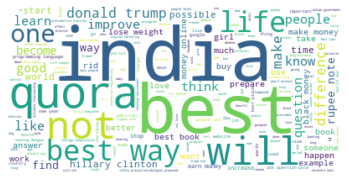

In [6]:
wc = WordCloud(background_color = "white" , max_words = len(textp_w) , stopwords=stop_words)
wc.generate(textp_w)
plt.imshow(wc , interpolation="bilinear")
plt.axis("off")
plt.show()



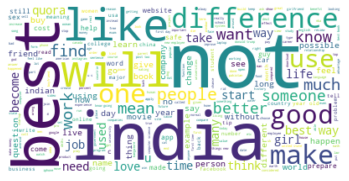

AttributeError: 'WordCloud' object has no attribute 'words_'

In [8]:
wc = WordCloud(background_color = "white" , max_words = len(textn_w) , stopwords=stop_words)
wc.generate(textn_w)
plt.imshow(wc , interpolation="bilinear")
plt.axis("off")
plt.show()




In [10]:
wc.process_text(textn_w)

{'step': 732,
 'guide': 164,
 'invest': 1040,
 'share': 940,
 'market': 683,
 'india': 15247,
 'story': 744,
 'kohinoor': 1,
 'koh': 9,
 'noor': 2,
 'diamond': 130,
 'happen': 3878,
 'indian': 2698,
 'government': 1349,
 'stole': 22,
 'back': 2039,
 'increase': 1449,
 'speed': 959,
 'internet': 973,
 'connection': 289,
 'using': 3161,
 'vpn': 147,
 'increased': 144,
 'hacking': 158,
 'dns': 19,
 'mentally': 63,
 'lonely': 97,
 'solve': 1098,
 'find': 6240,
 'remainder': 137,
 'math': 1286,
 'divided': 241,
 'one': 9942,
 'dissolve': 59,
 'water': 1668,
 'sugar': 177,
 'salt': 165,
 'methane': 25,
 'carbon': 104,
 'di': 13,
 'oxide': 29,
 'fish': 236,
 'survive': 397,
 'buy': 4141,
 'tiago': 3,
 'childern': 1,
 'active': 289,
 'far': 510,
 'phone': 1766,
 'video': 1460,
 'use': 8689,
 'instead': 1234,
 'motorola': 39,
 'company': 2835,
 'hack': 901,
 'charter': 9,
 'motorolla': 1,
 'dcx3400': 2,
 'free': 1977,
 'method': 690,
 'fresnel': 2,
 'biprism': 1,
 'tell': 2039,
 'durability': 1

## pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']



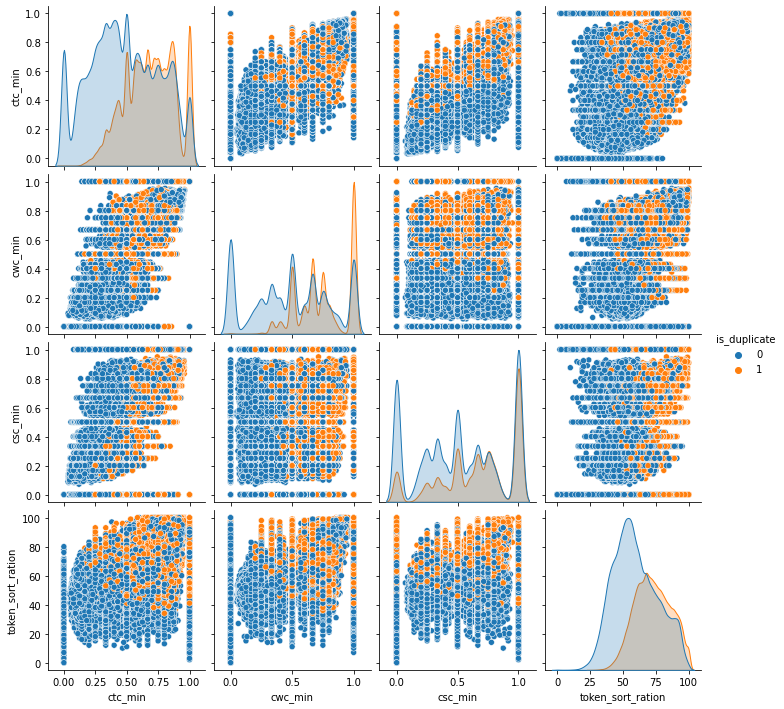

In [10]:
n = df.shape[0]
sns.pairplot(df[["ctc_min" , "cwc_min" , "csc_min" , "token_sort_ration" , "is_duplicate"]] , hue = "is_duplicate" )
plt.show()

<AxesSubplot:xlabel='is_duplicate', ylabel='token_sort_ration'>

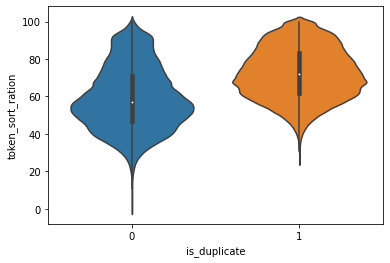

In [13]:
sns.violinplot( x = df["is_duplicate"] , y = df["token_sort_ration"] , data = df[0:] )

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='token_sort_ration', ylabel='Density'>

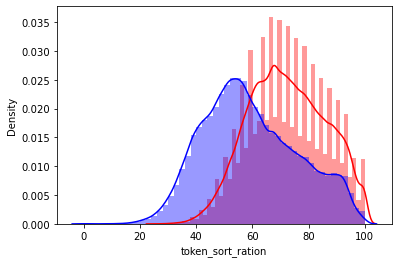

In [16]:
sns.distplot(df[df["is_duplicate"] == 1.0]["token_sort_ration"][0:] , color = "red" , label = "1")
sns.distplot(df[df["is_duplicate"] == 0.0]["token_sort_ration"][0:] , color = "blue" , label = "0")



## using tsne to visualise 15d into 2d

In [15]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ration' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values


In [16]:
tsne2d = TSNE(
    n_components=2,
    init="random",
    random_state=101,
    n_iter=1000,
).fit_transform(X)

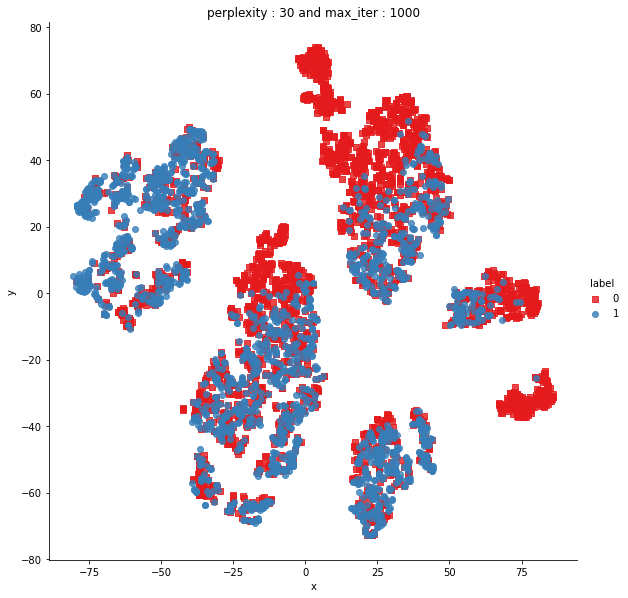

In [33]:
df_subset_tsne = pd.DataFrame({"x" : tsne2d[:,0] , "y" : tsne2d[:,1] , "label" : y})
sns.lmplot(data=df_subset_tsne, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1",markers=["s","o"])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

# this shows that the points are seperable using our data
